### Load dataset.

In [ ]:
from datasets import load_from_disk


cropped_datasets = load_from_disk("../data/interim/para-nmt-preprocessed-cropped")
cropped_datasets

### I will train several models and measure their performances.

In [33]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [34]:
from datasets import load_metric

!pip install sacrebleu

# Load the BLUE metric
metric = load_metric("sacrebleu")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
metric

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'exp'`. Possible values are:
        - `'none'`: no smoothing
        - `'floor'`: increment zero counts
        - `'add-k'`: increment num/deno

In [36]:
MAX_INPUT_LENGTH = 128
MAX_TARGET_LENGTH = 128

def preprocess_function(examples):
    # Tokenizer for inputs
    model_inputs = tokenizer(examples['reference'], max_length=MAX_INPUT_LENGTH, truncation=True)

    # Tokenizer for targets
    targets = tokenizer(examples['translation'], max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = targets["input_ids"]
    return model_inputs

In [38]:
BATCH_SIZE = 32


def get_model_args(model_name: str):
    return Seq2SeqTrainingArguments(
        f"{model_name}-finetuned-tox-to-detox",
        evaluation_strategy = "epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        weight_decay=0.01,
        save_total_limit=3,
        num_train_epochs=10,
        predict_with_generate=True,
        fp16=True,
        report_to='tensorboard',
        logging_steps=100
    )

In [39]:
import numpy as np

# simple postprocessing for text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


# compute metrics function to pass to trainer
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [40]:
def get_model_trainer(model, args, data_collator, tokenizer, tokenized_datasets):
    return Seq2SeqTrainer(
        model,
        args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

### Train models

#### blenderbot-small 90M was performing poorly in a way that it got less and less BLEU score with each epoch and inference time was too large. My assumption is that (some) models for text summarisation are not suitable for text-detoxification as well as translation models such as WMT19 or M4T

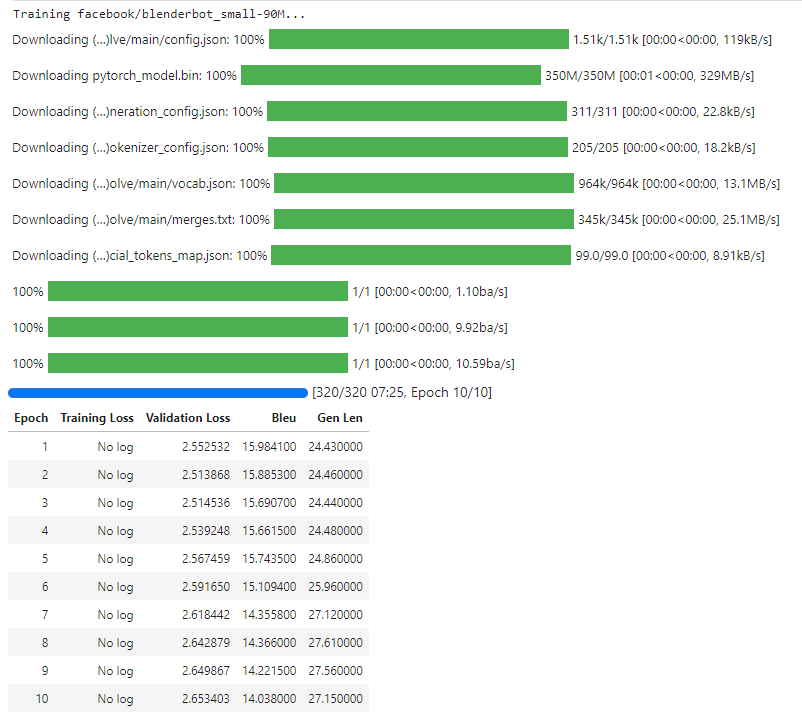

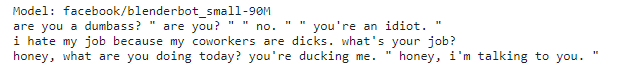

### Following models were considered and some of them tested:
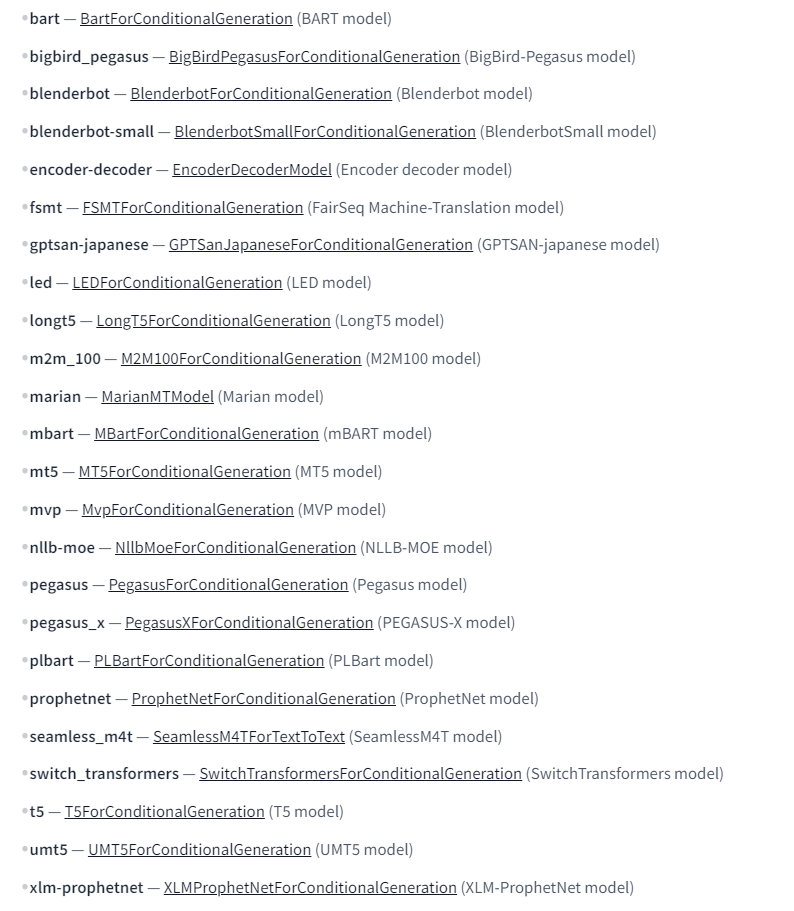

In [41]:
# Initialise models to train and compare.
MODEL_NAMES = [
#     "google/umt5-small"
    "facebook/bart-base",
#     "t5-base"
]
models_tokenizers = {}

# Loop through our models
for model_name in MODEL_NAMES:
    print(f"Training {model_name}...")
    
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=MAX_INPUT_LENGTH)
    models_tokenizers[model_name] = tokenizer
    
    tokenized_datasets = cropped_datasets.map(preprocess_function, batched=True)
    args = get_model_args(model_name)
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
    
    trainer = get_model_trainer(model, args, data_collator, tokenizer, tokenized_datasets)
    trainer.train()
    trainer.save_model(f"{model_name}_best")

Training facebook/bart-base...


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.798500,1.583685,28.051800,13.947000
2,1.577500,1.521235,29.504100,13.867000
3,1.481500,1.507685,29.163800,13.745000
4,1.364900,1.497973,29.694200,13.830000
5,1.329200,1.510446,29.865400,13.858000
6,1.267300,1.514316,29.490800,13.796000
7,1.189200,1.517302,29.681500,13.791000
8,1.164900,1.529555,29.353800,13.767000
9,1.146100,1.533751,29.628400,13.763000
10,1.125000,1.537330,29.549400,13.776000


### Using trained models, translate several sentences

In [42]:
def translate(model, inference_request, tokenizer) -> str:
    input_ids = tokenizer(inference_request, return_tensors="pt").input_ids
    outputs = model.generate(input_ids=input_ids)
    return tokenizer.decode(outputs[0], skip_special_tokens=True,temperature=0)

### Let's test the trained model

In [43]:
import time
import tqdm


test_references_texts = ['ARE YOU FUCKING IDIOT?', "I hate my job because my boss is asshole!", "Honey, you're looking dusgusting today."]

# Test results for each model
test_results = {}

# loading the models and translating sentences with them
for model_name in MODEL_NAMES:
    print(f"Model: {model_name}")
    
    model = AutoModelForSeq2SeqLM.from_pretrained(f'{model_name}_best')
    model.eval()
    model.config.use_cache = False
    
    for text in test_references_texts:
        print(translate(model, text, models_tokenizers[model_name]))
    print()
    
    # Detoxify test data
    model_test_translations = []
    model_test_labels = []
    
    tokenizer = models_tokenizers[model_name]
    tokenized_datasets = cropped_datasets.map(preprocess_function, batched=True)
    
    inference_time_sum = 0
    for i in tqdm(range(len(tokenized_datasets['test']))):
        
        # Inference
        start_time = time.time()
        model_translation = translate(model, tokenized_datasets['test'][i]['reference'], tokenizer)
        end_time = time.time()
        
        inference_time_sum += end_time - start_time
        
        model_test_translations.append(model_translation)
        model_test_labels.append([tokenized_datasets['test'][i]['translation']])
    
    test_results[model_name] = metric.compute(predictions=model_test_translations, references=model_test_labels)
    test_results[model_name]['average_inf_time'] = inference_time_sum / len(tokenized_datasets['test'])

Model: facebook/bart-base


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


are you kidding me?
I hate my job because my boss is a douche!
honey, you look terrible today.



  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

100%|██████████| 1000/1000 [10:33<00:00,  1.58it/s]


In [44]:
test_results

{'facebook/bart-base': {'score': 30.24226259127205,
  'counts': [6756, 3954, 2412, 1452],
  'totals': [9999, 8999, 7999, 7004],
  'precisions': [67.56675667566756,
   43.93821535726192,
   30.153769221152643,
   20.73101085094232],
  'bp': 0.8193696761052693,
  'sys_len': 9999,
  'ref_len': 11991}}

### Models test results
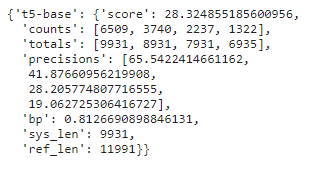
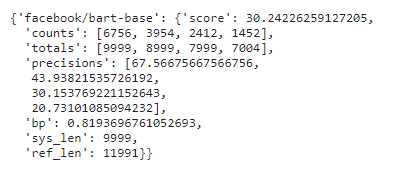

### Download model from Kaggle.

In [48]:
!zip -r bart_best.zip /kaggle/working/facebook/bart-base_best

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/facebook/bart-base_best/ (stored 0%)
  adding: kaggle/working/facebook/bart-base_best/tokenizer.json (deflated 72%)
  adding: kaggle/working/facebook/bart-base_best/special_tokens_map.json (deflated 52%)
  adding: kaggle/working/facebook/bart-base_best/tokenizer_config.json (deflated 50%)
  adding: kaggle/working/facebook/bart-base_best/training_args.bin (deflated 49%)
  adding: kaggle/working/facebook/bart-base_best/generation_config.json (deflated 45%)
  adding: kaggle/working/facebook/bart-base_best/vocab.json (deflated 59%)
  adding: kaggle/working/facebook/bart-base_best/pytorch_model.bin (deflated 8%)
  adding: kaggle/working/facebook/ba

### Visualisation

In [45]:
!pip install evaluate
import evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.10/site-packages/evaluate/visualization.py:47: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*ranges[j])
/opt/conda/lib/python3.10/site-packages/evaluate/visualization.py:56: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(*ranges[j])
/opt/conda/lib/python3.10/site-packages/evaluate/visualization.py:124: RuntimeWarning: invalid value encountered in double_scalars
  sdata.append((d - y1) / (y2 - y1) * (x2 - x1) + x1)


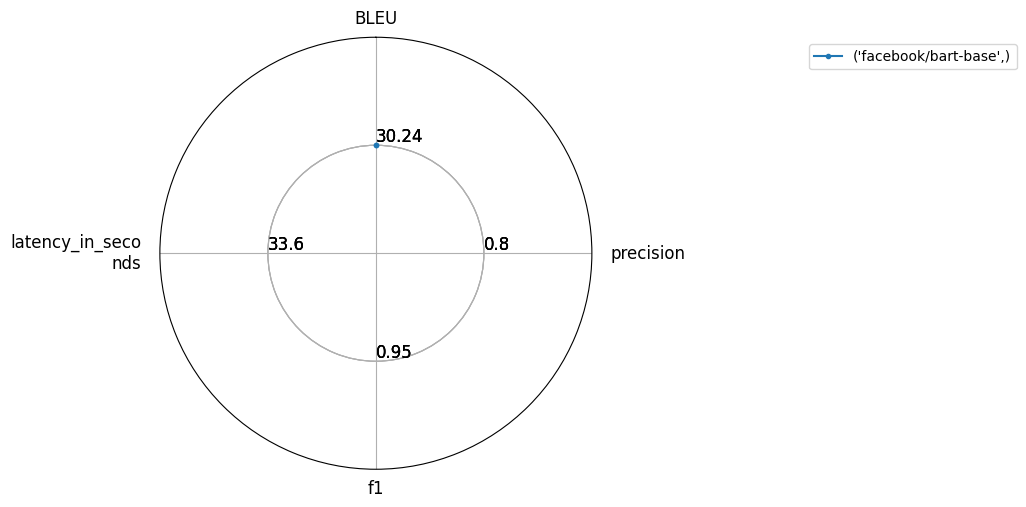

In [46]:
from evaluate.visualization import radar_plot


data = []
for model_name in MODEL_NAMES:
    data.append({"BLEU": test_results[model_name]['score'], 
                 "Average inference time": test_results[model_name]['average_inf_time']
                })
plot = radar_plot(data=data, model_names=MODEL_NAMES)
plot.show()